# Strain plots using one dataframe
In the other Notebook, I use several different dataframes to hold analyzed data, and it's pretty messy. In this Notebook, I want to clean things up and use only a few dataframes:
- Metadata from all trials
- Mitochondrial position information from all trials
    - experiment id
    - x, y, z coordinates
    - displacement in x, y, and z directions
    - particle id
    - frame number
    - acutation pressure
    - worm strain name
    - genotype
- Pairwise measurements from mitochondria
    - experiment id
    - pair id
    - particle ids
    - frame number
    - actuation pressure
    - worm strain name
    - current distance between pairs
    - rest distance between pairs
    - stretch
    - strain

## Setup
### Choose worm strain and neuron

In [1]:
worm_strains = ['NM3573', 'GN885', 'GN886', 'GN887']#, 'GN906']
neurons = ['ALM']

allele_dict = {'NM3573': 'wild-type',
               'GN885': 'him-4(e1267)',
               'GN886': 'mec-1(e1066)',
               'GN887': 'mec-1(e1738)',
               'GN906': 'mec-5(u444)'}

### Experimental parameters

In [2]:
pixel_to_micron = 0.275
analyzed_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_AnalyzedData/'
raw_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/'
fig_save_dir = analyzed_data_dir + 'PreliminaryPlots/'

### Import packages

In [3]:
import yaml
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy import stats
from scipy.optimize import curve_fit
import pims
from nd2reader import ND2Reader 
import math
import warnings
import glob
import numpy as np
import typing
import pathlib
import seaborn as sns
import pathlib
import line_profiler

start = time.time()
for current_worm_strain in worm_strains:
    for current_neuron in neurons:
        current_strain_TRN = current_worm_strain + '_' + current_neuron
        fig_path = pathlib.Path(fig_save_dir + current_strain_TRN)
        if fig_path.exists() is False:
            fig_path.mkdir()

## Load data
### Start with metadata

In [4]:
analyzed_trials = glob.iglob(analyzed_data_dir + '*')
all_metadata = []
for trial in analyzed_trials:
    try:
        with open(trial + '/metadata.yaml') as metadata_file:
            all_metadata.append(yaml.safe_load(metadata_file))
    except FileNotFoundError:
        pass
    except NotADirectoryError:
        pass

metadata_df = pd.DataFrame(all_metadata)

#### Select only the trials that have been successfully processed
Also get a count of the number of trials for each genotype

In [5]:
trials_for_analysis = metadata_df.loc[(metadata_df['analysis_status'] == 'Strain calculated') &
                                                   (metadata_df['actuator_center'].notnull()) &
                                                   (metadata_df['neuron'].isin(neurons)) &
                                                   (metadata_df['worm_strain'].isin(worm_strains))].copy()

worm_strain_categories = pd.api.types.CategoricalDtype(categories=worm_strains, ordered=True)
# trials_for_analysis['sortable_strain_names'] = trials_for_analysis.loc[trials_for_analysis['worm_strain']].astype(worm_strain_categories)
trials_for_analysis['worm_strain'] = trials_for_analysis['worm_strain'].astype(worm_strain_categories)#= pd.Categorical(trials_for_analysis['worm_strain'])
trials_for_analysis.sort_values('worm_strain', inplace=True)
display(trials_for_analysis)
n_trials_dict = trials_for_analysis['worm_strain'].value_counts().to_dict()

,Experiment_id,actuator_center,actuator_corners,actuator_thickness,analysis_status,bleach_time,cultivation_temp,device_ID,head_orientation,microscope,...,slice_height_pix,slice_width_pix,stack_height,timestamp,total_images,trial_rating,user,vulva_orientation,worm_life_stage,worm_strain
47,SSN_148_001,"[223.0, 479.0]","[224.0, 391.0, 222.0, 567.0]",22.999806,Strain calculated,2019-01-29 01:30:00,20,Y4P7-4,Tailfirst,Spinning Disk Confocal in CSIF Shriram,...,1050,600,72,2019-02-01 15:24:15,792,⭐️⭐️⭐️⭐️,anekimke@stanford.edu,East,YA,NM3573
68,SSN_168_001,"[405.0, 526.0]","[407.0, 437.0, 403.0, 615.0]",20.000000,Strain calculated,2019-02-10 10:00:00,20,Y4P7-3,Tailfirst,Spinning Disk Confocal in CSIF Shriram,...,1070,600,60,2019-02-13 15:32:47,660,⭐️⭐️⭐️⭐️,anekimke@stanford.edu,West,YA,NM3573
66,SSN_166_001,"[370.5, 529.5]","[375.0, 439.0, 366.0, 620.0]",20.000000,Strain calculated,2019-02-10 10:00:00,20,Y4P7-3,Headfirst,Spinning Disk Confocal in CSIF Shriram,...,1070,600,57,2019-02-13 15:02:15,627,⭐️⭐️⭐️⭐️,anekimke@stanford.edu,West,YA,NM3573
65,SSN_165_001,"[224.5, 520.0]","[229.0, 434.0, 220.0, 606.0]",20.000000,Strain calculated,2019-02-10 10:00:00,20,Y4P7-3,Tailfirst,Spinning Disk Confocal in CSIF Shriram,...,1070,600,60,2019-02-13 14:53:39,660,⭐️⭐️⭐️,anekimke@stanford.edu,East,YA,NM3573
63,SSN_163_001,"[376.5, 542.0]","[377.0, 455.0, 376.0, 629.0]",27.999868,Strain calculated,2019-02-10 10:00:00,20,Y4P7-3,Tailfirst,Spinning Disk Confocal in CSIF Shriram,...,1070,600,52,2019-02-13 14:26:40,572,⭐️⭐️⭐️,anekimke@stanford.edu,West,YA,NM3573
62,SSN_162_001,"[224.0, 517.5]","[230.0, 429.0, 218.0, 606.0]",55.055122,Strain calculated,2019-02-10 10:00:00,20,Y4P7-3,Tailfirst,Spinning Disk Confocal in CSIF Shriram,...,1070,600,56,2019-02-13 14:08:57,616,⭐️⭐️⭐️,anekimke@stanford.edu,East,YA,NM3573
61,SSN_161_001,"[243.5, 559.5]","[247.0, 475.0, 240.0, 644.0]",22.997430,Strain calculated,2019-02-03 01:15:00,20,Y4P7-3,Headfirst,Spinning Disk Confocal in CSIF Shriram,...,1052,600,54,2019-02-06 13:34:51,594,⭐️⭐️⭐️,anekimke@stanford.edu,East,YA,NM3573
67,SSN_167_001,"[214.5, 536.5]","[219.0, 448.0, 210.0, 625.0]",20.000000,Strain calculated,2019-02-10 10:00:00,20,Y4P7-3,Tailfirst,Spinning Disk Confocal in CSIF Shriram,...,1070,600,53,2019-02-13 15:17:12,583,⭐️⭐️,anekimke@stanford.edu,East,YA,NM3573
59,SSN_159_001,"[359.5, 505.5]","[363.0, 421.0, 356.0, 590.0]",23.955189,Strain calculated,2019-02-03 01:15:00,20,Y4P7-3,Tailfirst,Spinning Disk Confocal in CSIF Shriram,...,1052,600,62,2019-02-06 13:00:46,682,⭐️⭐️⭐️,anekimke@stanford.edu,West,YA,NM3573
58,SSN_158_001,"[206.5, 469.5]","[212.0, 383.0, 201.0, 556.0]",30.850920,Strain calculated,2019-02-03 01:15:00,20,Y4P7-3,Headfirst,Spinning Disk Confocal in CSIF Shriram,...,1052,600,66,2019-02-06 12:52:40,726,⭐️⭐️⭐️,anekimke@stanford.edu,East,YA,NM3573


In [6]:
worm_strain_categories

CategoricalDtype(categories=['NM3573', 'GN885', 'GN886', 'GN887'], ordered=True)

### Load mitochondria position data

In [7]:
list_of_linked_mito_dfs = []
linked_mitos_df = pd.DataFrame()
for index, row in trials_for_analysis.iterrows():
    experiment_id = row['Experiment_id']
    linked_mitos_file = analyzed_data_dir + experiment_id + '/mito_locations.yaml'
    with open(linked_mitos_file, 'r') as yamlfile:
        linked_mitos_dict = yaml.safe_load(yamlfile)

    parsed_dict = {k: linked_mitos_dict[k] for k in (
        'frame', 'particle', 'pressure', 'x', 'y', 'z')}
    parsed_df = pd.DataFrame(parsed_dict)
    parsed_df['Experiment_id'] = experiment_id
    parsed_df['worm_strain'] = row['worm_strain']
    parsed_df['genotype'] = allele_dict[row['worm_strain']]
    list_of_linked_mito_dfs.append(parsed_df)

linked_mitos_df = pd.concat(list_of_linked_mito_dfs)

## Find displacements from position data 
### Correct y value for actuator location and worm head direction
A y coordinate of 0 is the center of the actuator, and negative values correspond to the anterior side of the worm

In [8]:
def correct_y_value(row):
    current_metadata = trials_for_analysis.loc[trials_for_analysis['Experiment_id'] == row['Experiment_id']]

    if current_metadata['head_orientation'].str.contains('Headfirst').all():
        worm_head_direction = -1
    elif current_metadata['head_orientation'].str.contains('Tailfirst').all():
        worm_head_direction = 1
    else:
        raise ValueError

    yval_middle_of_actuator = current_metadata['actuator_center'].values[0][1]
    
    return worm_head_direction * (row['y'] - yval_middle_of_actuator)

linked_mitos_df['y'] = linked_mitos_df.apply(correct_y_value, axis=1)
# linked_mitos_df['y_pixel'] = linked_mitos_df['y']

### Convert coordinates from pixels to microns

In [9]:
for coord in ['x', 'y', 'z']:
    linked_mitos_df[coord] = linked_mitos_df[coord] * pixel_to_micron

### Find rest locations
The rest location is the "undeformed" reference location for a particular mitochondrion. This is not truly undeformed since the worm is compressed in the trap, but it corresponds to the reference configuration for calculating strain

In [10]:
def find_rest_locations(row, dimension):
    if row['pressure'] == 0:
        rest_dist = row[dimension]
    elif row['pressure'] != 0:
        rest_dist = linked_mitos_df.loc[
            (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
            (linked_mitos_df['frame'] == row['frame'] - 1) &
            (linked_mitos_df['particle'] == row['particle'])][dimension].values[0]
    
    return rest_dist

for dimension in ['x', 'y', 'z']:
    linked_mitos_df[dimension + '_rest'] = linked_mitos_df.apply(
        find_rest_locations, dimension=dimension, axis=1)

### Calculate displacements
The displacement of a mitochondrion is the distance between its current location and its rest location.

In [11]:
def calc_distance(row, dimension):
#     print([row[dim] for dim in list(dimension)])
    return distance.euclidean([row[dim] for dim in list(dimension)],
                              [row[dim + '_rest'] for dim in list(dimension)])

for dimension in ['x', 'y', 'z', 'xz', 'xyz']:
    linked_mitos_df[dimension + '_dist'] = linked_mitos_df.apply(
        calc_distance, dimension=dimension, axis=1)

def calc_displacement(row, dimension):
    return row[dimension] - row[dimension + '_rest']

for dimension in ['x', 'y', 'z']:
    linked_mitos_df[dimension + '_disp'] = linked_mitos_df.apply(
        calc_displacement, dimension=dimension, axis=1)

In [12]:
# linked_mitos_df.loc[linked_mitos_df['pressure'] != 0].head()

### Fit gaussian to displacement profile to interpolate max displacement 

In [13]:
def transformed_normal(x, loc, scale, mag):
    return mag * stats.norm.pdf(x, loc, scale)

def calc_max_dist_from_norm_fit(row):
    max_dist = transformed_normal(row['max_dist_location'],
                                  row['max_dist_location'],
                                  row['normal_scale_param'],
                                  row['normal_magnitude_param'])
    return max_dist

fit_param_list = []
for index, trial in trials_for_analysis.iterrows():
#     print(trial)
    trials_with_actuation = linked_mitos_df.loc[
        (linked_mitos_df['Experiment_id'] == trial['Experiment_id']) &
        (linked_mitos_df['pressure'] == 300)]
    popt_norm, pcov_norm = curve_fit(
        transformed_normal,
        trials_with_actuation['y'],
        trials_with_actuation['x_dist'],
        p0=(0, 20, 400),
        maxfev=1000000)#,
#         bounds=((-5, 1, 50),
#                 (5, 100, 500)))
    fit_param_dict = {
        'Experiment_id': trial['Experiment_id'],
        'worm_strain': trial['worm_strain'],
        'genotype': allele_dict[trial['worm_strain']], 
        'max_dist_location': popt_norm[0],
        'normal_scale_param': popt_norm[1],
        'normal_magnitude_param': popt_norm[2]
    }
    fit_param_list.append(fit_param_dict)
fit_param_df = pd.DataFrame(fit_param_list)
fit_param_df['max_dist'] = fit_param_df.apply(calc_max_dist_from_norm_fit, axis=1)

### Correct y values using interpolated location of actuator center
By fitting a gaussian to the displacement profile, we get a value for how far the peak of the gaussian needed to be shifted. This is our best estimate of the center position of the actuator, since that is where the actuation is greatest. As a result, we correct the longitudinal coordinate again.

In [14]:
def correct_y_using_fit(row, dimension):
    interpolated_center = fit_param_df.loc[
        fit_param_df['Experiment_id'] == row['Experiment_id']][
        'max_dist_location'].values[0]
    return row[dimension] - interpolated_center

# linked_mitos_df['original_y'] = linked_mitos_df['y'].copy()
linked_mitos_df['y'] = linked_mitos_df.apply(correct_y_using_fit, dimension='y', axis=1)
linked_mitos_df['y_rest'] = linked_mitos_df.apply(correct_y_using_fit, dimension='y_rest', axis=1)

## Plots of mitochondria locations and displacements

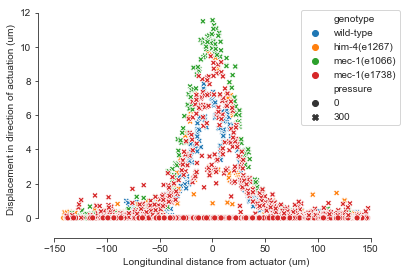

In [15]:
sns.set_style("ticks")

fig, ax = plt.subplots()
ax = sns.scatterplot(x='y', y='x_dist', data=linked_mitos_df, hue='genotype', style='pressure')
sns.despine(ax=ax, offset=10, trim=True)
ax.set_xlabel('Longitundinal distance from actuator (um)')
ax.set_ylabel('Displacement in direction of actuation (um)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
fig.savefig(fig_save_dir + 'x_disp_vs_position', bbox_inches='tight')

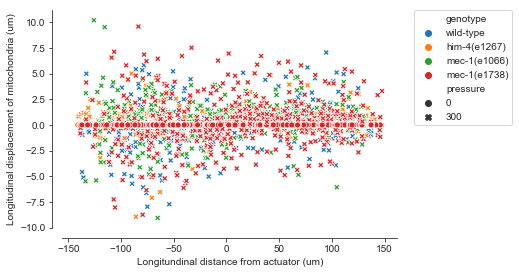

In [16]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x='y', y='y_disp', data=linked_mitos_df, hue='genotype', style='pressure')
sns.despine(ax=ax, offset=10)
ax.set_xlabel('Longitundinal distance from actuator (um)')
ax.set_ylabel('Longitudinal displacement of mitochondria (um)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);

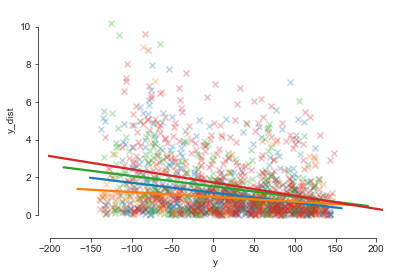

In [17]:
fig, ax = plt.subplots()
for this_strain in worm_strains:
    sns.regplot(x='y', y='y_dist', x_ci=None, ci=None, marker='x', scatter_kws={'alpha':0.3},
                data=linked_mitos_df.loc[(linked_mitos_df['pressure'] == 300) &
                                         (linked_mitos_df['worm_strain'] == this_strain)])
sns.despine(ax=ax, offset=10, trim=True)
# plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);

### Interpolated max displacement
This shouldn't vary between genotypes, since the actuator is applying the same displacement regardless of genotype.

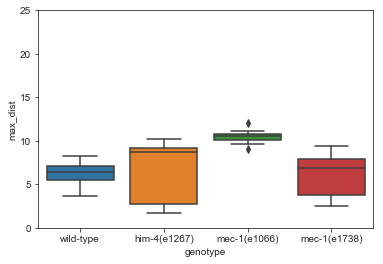

In [18]:
ax = sns.boxplot(x='genotype', y='max_dist', data=fit_param_df)
ax.set_ybound(-0,25)

### Plot showing distribution of mitochondria along TRNs


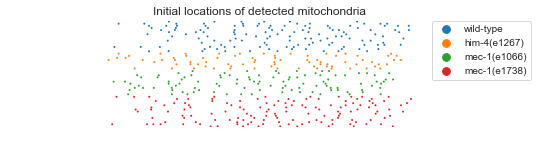

In [19]:
ax = sns.stripplot(x='y', y='Experiment_id', hue='genotype', dodge=True, size=2,
              data=linked_mitos_df[linked_mitos_df['frame'] == 0])
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_aspect(2)
ax.axis('off')
ax.set_title('Initial locations of detected mitochondria');

### Plot showing how many mitochondria were tracked in each trial

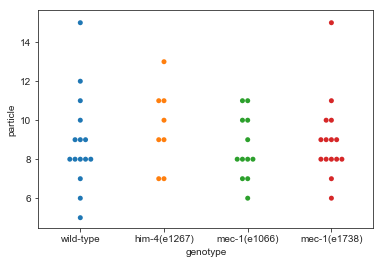

In [20]:
particle_count_df = linked_mitos_df.loc[
    linked_mitos_df['frame'] == 0].groupby(
    ['Experiment_id', 'genotype'], as_index=False).count()
ax = sns.swarmplot(x='genotype', y='particle',
                  data=particle_count_df)
# particle_count_df['frame'].mean() #.describe()

### Number of frames per trial
We couldn't successfully track the position of the mitochondria through all stacks of every trial. This plot shows how many stacks were usable for the trials where some stacks were successfully analyzed.

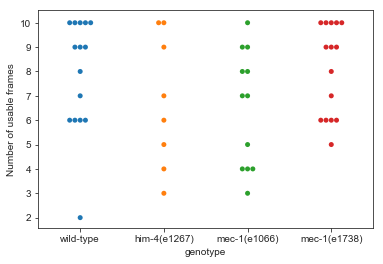

In [21]:
ax = sns.swarmplot(x='genotype', y='frame',
                   data=linked_mitos_df.groupby('Experiment_id', as_index=False).max())
ax.set_ylabel('Number of usable frames');

### Plot displacement data along with fit

In [22]:
# ax = sns.scatterplot(x='y', y='x_dist', 
#                      data=linked_mitos_df,#.loc[linked_mitos_df['Experiment_id']=='SSN_150_001'],
#                      hue='genotype', style='pressure')
# sns.despine(ax=ax, offset=10)
# ax.set_xlabel('Longitundinal distance from actuator (um)')
# ax.set_ylabel('Displacement in direction of actuation (um)')
# plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# plot_bounds = ax.get_xbound()
# x_coords =  np.linspace(round(plot_bounds[0]), round(plot_bounds[1]))
# for index, row in fit_param_df.iterrows():#[fit_param_df['Experiment_id']=='SSN_150_001'].iterrows():
#     color = ['b' if (row['worm_strain'] == 'NM3573') else 'r']
#     ax.plot(x_coords, transformed_normal(x_coords,
#                                          row['max_dist_location'],
#                                          row['normal_scale_param'],
#                                          row['normal_magnitude_param']),
#            color=color[0], alpha=0.1)

In [23]:
# n = trials_for_analysis.shape[0]
# fig, axes = plt.subplots(n, 1, figsize=(5, n*4), constrained_layout=True)
# i=0
# for index, trial in trials_for_analysis.iterrows():
#     sns.scatterplot(x='y', y='x_dist', 
#                      data=linked_mitos_df.loc[linked_mitos_df['Experiment_id']==trial['Experiment_id']],
#                      hue='genotype', style='pressure', ax=axes[i])
#     axes[i].plot(x_coords, transformed_normal(
#         x_coords,
#         fit_param_df.loc[fit_param_df['Experiment_id'] ==trial[
#             'Experiment_id']]['max_dist_location'].values[0],
#         fit_param_df.loc[fit_param_df['Experiment_id'] ==trial[
#             'Experiment_id']]['normal_scale_param'].values[0],
#         fit_param_df.loc[fit_param_df['Experiment_id'] ==trial[
#             'Experiment_id']]['normal_magnitude_param'].values[0]),
#            color='b')#, alpha=0.1)
# #     sns.scatterplot(x='original_y', y='x_dist', 
# #                      data=linked_mitos_df.loc[linked_mitos_df['Experiment_id']==trial['Experiment_id']],
# #                      hue='genotype', style='pressure', ax=axes[i], hue_order=[1,0])
#     linked_mitos_df.plot(x='original_y', y='x_dist', kind='scatter', color='r')
#     axes[i].plot(x_coords, transformed_normal(
#         x_coords,
#         0,
#         fit_param_df.loc[fit_param_df['Experiment_id'] ==trial[
#             'Experiment_id']]['normal_scale_param'].values[0],
#         fit_param_df.loc[fit_param_df['Experiment_id'] ==trial[
#             'Experiment_id']]['normal_magnitude_param'].values[0]),
#            color='r')#, alpha=0.1)
#     axes[i].set_title(trial['Experiment_id'])
#     i+=1
# # ax.set_ybound(-.1,.1)

In [24]:
# # fit_param_df.boxplot('max_dist_location')
# sns.swarmplot(y='max_dist_location', data=fit_param_df)

In [25]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# #     print(df)
#     display(linked_mitos_df)

## Create dataframe with data for pairs of adjacent mitochondria
- experiment id
- pair id
- particle ids
- frame number
- actuation pressure
- worm strain name
- genotype
- current distance between pairs
- stretch
- strain
### Match adjacent mitochondria into pairs

In [26]:
mito_pair_df_list = []
linked_mitos_df.sort_values(['worm_strain', 'Experiment_id', 'frame', 'y'], inplace=True)
for trial in linked_mitos_df['Experiment_id'].unique():
    for frame in linked_mitos_df.loc[linked_mitos_df['Experiment_id'] == trial]['frame'].unique():
        pair_count = 0
        # create iterrator to go through the particles of only this frame
        iterrator = linked_mitos_df.loc[
                (linked_mitos_df['Experiment_id'] == trial) &
                (linked_mitos_df['frame'] == frame)].iterrows() 
        # skip the first one, since we want to make pairs
        previous_index, previous_row = next(iterrator)
#         previous_row = first_row['particle']
        for index, row in iterrator:
            this_dist = distance.euclidean(previous_row[['x', 'y', 'z']], row[['x', 'y', 'z']])
            rest_dist = distance.euclidean(
                previous_row[['x_rest', 'y_rest', 'z_rest']], row[['x_rest', 'y_rest', 'z_rest']])
            this_mito_pair_dict = {
                'Experiment_id': row['Experiment_id'],
                'frame': row['frame'],
                'particle_1': previous_row['particle'],
                'particle_1_yval': previous_row['y'],
                'particle_2': row['particle'],
                'particle_2_yval': row['y'],
                'pair_id': pair_count,
                'pressure': row['pressure'],
                'worm_strain': row['worm_strain'],
                'genotype': row['genotype'],
                'distance': this_dist,
                'rest_dist': rest_dist}
            for dim in ['x', 'y', 'z']:
                this_mito_pair_dict[dim + '_dist'] = distance.euclidean(previous_row[dim], row[dim])
                this_mito_pair_dict[dim + '_rest_dist'] = distance.euclidean(
                    previous_row[dim + '_rest'],
                    row[dim + '_rest'])
            mito_pair_df_list.append(this_mito_pair_dict)
            pair_count += 1
            previous_row = row

mito_pair_df = pd.DataFrame(mito_pair_df_list)
mito_pair_df['worm_strain'] = mito_pair_df['worm_strain'].astype(worm_strain_categories)

In [27]:
mito_pair_df.sort_values('worm_strain').head()

,Experiment_id,distance,frame,genotype,pair_id,particle_1,particle_1_yval,particle_2,particle_2_yval,pressure,rest_dist,worm_strain,x_dist,x_rest_dist,y_dist,y_rest_dist,z_dist,z_rest_dist
3329,SSN_168_001,6.686329,10,wild-type,9,3,116.940413,1,123.531212,0,6.686329,NM3573,0.442561,0.442561,6.590799,6.590799,1.035617,1.035617
2639,SSN_159_001,35.110654,3,wild-type,2,5,10.562189,11,45.600665,300,35.477312,NM3573,2.248975,2.108859,35.038475,35.413457,0.073177,0.281848
2638,SSN_159_001,30.533656,3,wild-type,1,7,-19.911743,5,10.562189,300,29.496682,NM3573,1.658058,0.342397,30.473932,29.493956,0.945745,0.208716
2637,SSN_159_001,33.989248,3,wild-type,0,8,-53.744069,7,-19.911743,300,34.961095,NM3573,3.057661,0.003543,33.832326,34.949575,1.137276,0.897408
2636,SSN_159_001,50.668924,2,wild-type,6,4,87.282404,1,137.918163,0,50.668924,NM3573,1.832831,1.832831,50.635759,50.635759,0.021477,0.021477


### Calculate stretch and strain

In [28]:
def calc_stretch(row, dim=None):
    if dim is not None:
        stretch = row[dim + '_dist'] - row[dim + '_rest_dist']
    else:
        stretch = row['distance'] - row['rest_dist']
    return stretch

def calc_strain(row, dim=None):
    if dim is not None:
        strain = row[dim + '_stretch'] / row[dim + '_rest_dist']
    else:
        strain = row['stretch'] / row['rest_dist']
    return strain
#     return row['stretch'] / row['rest_dist']

mito_pair_df['stretch'] = mito_pair_df.apply(calc_stretch, axis=1)
mito_pair_df['strain'] = mito_pair_df.apply(calc_strain, axis=1)
for dim in ['x', 'y', 'z']:
    mito_pair_df[dim + '_stretch'] = mito_pair_df.apply(calc_stretch, dim=dim, axis=1)
    mito_pair_df[dim + '_strain'] = mito_pair_df.apply(calc_strain, dim=dim, axis=1)

### Get spatial distribution of strain

In [29]:
spatial_strain_avg_list = []
for index, row in mito_pair_df.iterrows():
    y1_pixel = math.ceil(row['particle_1_yval'] / pixel_to_micron)
    y2_pixel = math.floor(row['particle_2_yval'] / pixel_to_micron)
    for y_coord in range(y1_pixel, y2_pixel):
        new_row_dict = {
            'Experiment_id': row['Experiment_id'],
            'frame': row['frame'],
            'pair_id': pair_count,
            'pressure': row['pressure'],
            'worm_strain': row['worm_strain'],
            'genotype': row['genotype'],
            'stretch': row['stretch'],
            'strain': row['strain'],
            'x_stretch': row['x_stretch'],
            'x_strain': row['x_strain'],
            'y_stretch': row['stretch'],
            'y_strain': row['y_strain'],
            'z_stretch': row['z_stretch'],
            'z_strain': row['z_strain'],
            'y_coord': y_coord,
            'y': y_coord * pixel_to_micron}
        spatial_strain_avg_list.append(new_row_dict)
            
spatial_strain_df = pd.DataFrame(spatial_strain_avg_list)
spatial_strain_df['worm_strain'] = spatial_strain_df['worm_strain'].astype(worm_strain_categories)
spatial_strain_df.sort_values('worm_strain', inplace=True)

## Plots of strain
### Plot strain at middle of actuator

112.12409806251526


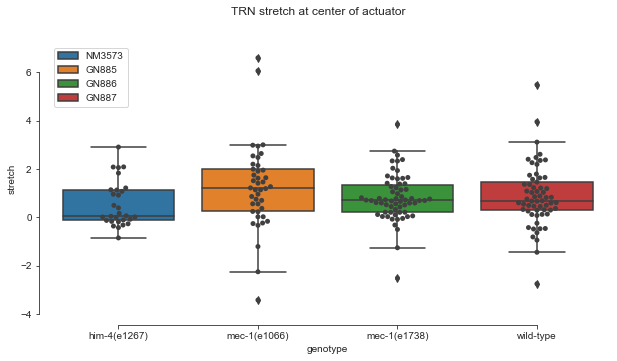

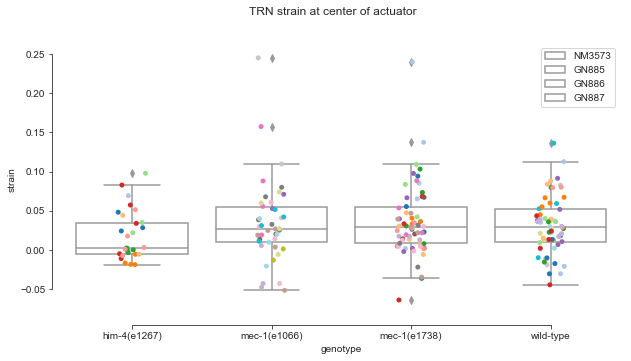

In [30]:
sns.set_style('ticks')
central_mito_pair_df = mito_pair_df.loc[
    ((mito_pair_df['particle_1_yval'] < 0) != 
     (mito_pair_df['particle_2_yval'] < 0)) &
    (mito_pair_df['pressure'] != 0)].copy()
central_mito_pair_df['worm_strain'] = central_mito_pair_df['worm_strain'].astype(worm_strain_categories)

n_actuations = {}
for this_strain in worm_strains:
    n_by_strain = central_mito_pair_df[central_mito_pair_df['worm_strain'] == this_strain].shape[0]
    n_actuations[allele_dict[this_strain]] = n_by_strain

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='genotype', y='stretch', data=central_mito_pair_df, ax=ax)
sns.swarmplot(x='genotype', y='stretch', color=".25", data=central_mito_pair_df, ax=ax)
ax.legend(ax.artists, worm_strains)
fig.suptitle('TRN stretch at center of actuator')
sns.despine(offset=10, trim=True)
# n_trials_text = [allele_dict[strain_name] + ': ' for strain_name in worm_strains]
# text_obj = mpl.offsetbox.AnchoredText(n_trials_text, loc="upper right", frameon=False)
# ax.add_artist(text_obj)
# ax.set_xlabel(('x1', 'x2'))

fig2, ax2 = plt.subplots(figsize=(10,5))
ax2 = sns.boxplot(x='genotype', y='strain', data=central_mito_pair_df, ax=ax2, color='white')
sns.stripplot(x='genotype', y='strain', hue='Experiment_id', ax=ax2, palette='tab20',
              data=central_mito_pair_df,)
fig2.suptitle('TRN strain at center of actuator')
sns.despine(offset=10, trim=True)
# ax2.legend(ax2.artists, worm_strains)
fig2.savefig(fig_save_dir + 'StrainAtCenter')

print(time.time()-start)

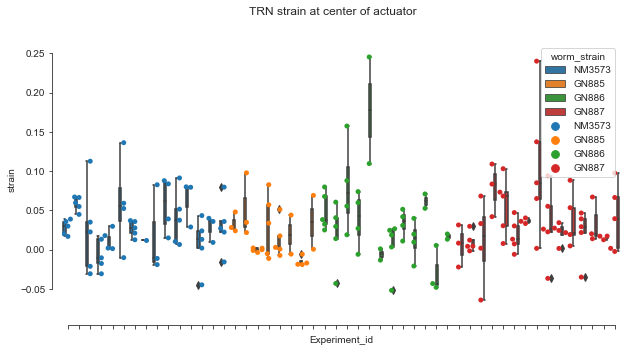

In [31]:
fig, ax = plt.subplots(figsize=(10,5))
sns.swarmplot(x='Experiment_id', y='strain', hue='worm_strain', ax=ax,
              data=central_mito_pair_df.sort_values('worm_strain'))
ax.legend(ax.artists, worm_strains)
sns.boxplot(x='Experiment_id', y='strain', hue='worm_strain', ax=ax,
            data=central_mito_pair_df.sort_values('worm_strain'))
fig.suptitle('TRN strain at center of actuator')
sns.despine(offset=10, trim=True)
# ax.legend()#ax.artists, worm_strains)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, ha='right');

In [32]:
central_mito_pair_df

,Experiment_id,distance,frame,genotype,pair_id,particle_1,particle_1_yval,particle_2,particle_2_yval,pressure,...,z_dist,z_rest_dist,stretch,strain,x_stretch,x_strain,y_stretch,y_strain,z_stretch,z_strain
7,SSN_169_001,39.191643,1,him-4(e1267),1,11,-25.605115,5,13.424241,300,...,1.274193,1.582358,1.077840,0.028280,2.387735,2.541394,0.960006,0.025217,-0.308165,-0.194750
19,SSN_169_001,39.153682,3,him-4(e1267),1,11,-24.305799,5,14.715729,300,...,1.353115,2.076764,0.921411,0.024100,2.039222,2.327067,0.855761,0.022422,-0.723649,-0.348450
31,SSN_169_001,39.986826,5,him-4(e1267),1,11,-20.738161,5,19.172252,300,...,2.328225,2.362054,1.833962,0.048069,-0.076199,-0.084330,1.841459,0.048372,-0.033829,-0.014322
50,SSN_173_001,32.217468,1,him-4(e1267),4,7,-16.587148,8,15.577853,300,...,0.670942,0.200787,2.084450,0.069175,-0.115986,-0.063481,2.088094,0.069425,0.470156,2.341564
70,SSN_173_001,31.978327,3,him-4(e1267),4,7,-17.745870,8,14.180794,300,...,0.625828,0.632080,0.020245,0.000633,0.484184,0.396332,-0.001804,-0.000056,-0.006252,-0.009891
87,SSN_175_001,18.513925,1,him-4(e1267),3,4,-2.973731,5,15.516798,300,...,0.001531,0.061141,-0.356247,-0.018879,0.343550,0.585345,-0.370415,-0.019639,-0.059610,-0.974954
103,SSN_175_001,18.408284,3,him-4(e1267),3,4,-2.569461,5,15.821819,300,...,0.011630,0.028923,-0.104158,-0.005626,0.267595,0.511291,-0.113741,-0.006146,-0.017293,-0.597901
119,SSN_175_001,18.380638,5,him-4(e1267),3,4,-2.075147,5,16.291916,300,...,0.099844,0.033884,-0.315466,-0.016873,0.437265,1.669359,-0.327176,-0.017501,0.065960,1.946624
134,SSN_175_001,44.899184,7,him-4(e1267),2,11,-44.787805,4,0.096993,300,...,0.395923,0.256597,-0.846632,-0.018507,-1.522271,-0.588307,-0.787057,-0.017233,0.139326,0.542974
157,SSN_177_001,22.737796,1,him-4(e1267),5,11,-2.933690,10,19.735811,300,...,0.448791,0.086257,0.960447,0.044103,-0.018008,-0.010465,0.960421,0.044241,0.362534,4.202962


### Strain at center vs. time

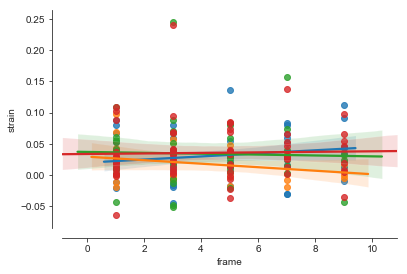

In [33]:
fig, ax = plt.subplots()
sns.despine(offset=10)
for this_strain in worm_strains:
    sns.regplot(x='frame', y='strain', ax=ax,
                data=central_mito_pair_df.loc[central_mito_pair_df['worm_strain'] == this_strain])

### Plot strain using spatial averaging

Plot took 122 seconds.


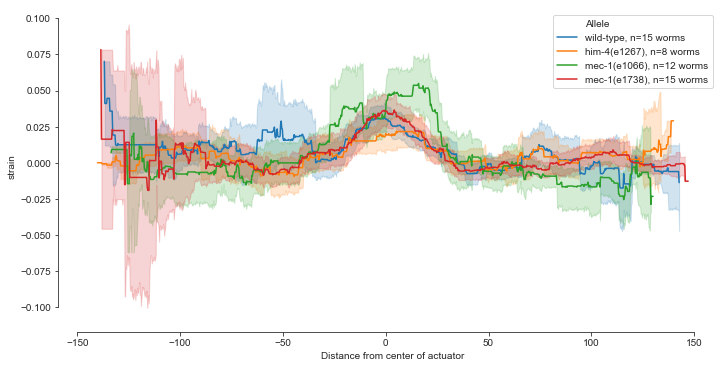

In [34]:
plot_start = time.time()
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
sns.lineplot(x='y', y='strain', ax=ax, hue='worm_strain', ci=None, # style='',
             data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300)]) # &
#                                         (spatial_strain_df['y_coord'] > -100) &
#                                         (spatial_strain_df['y_coord'] < 100)])

sns.despine(offset=10, trim=True)
h, labels = ax.get_legend_handles_labels()
labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label]) + ' worms') if label in allele_dict else 'Allele' for label in labels]
ax.legend(h, labels)
ax.set_xlabel('Distance from center of actuator')
fig.savefig(fig_save_dir + 'StrainVsPosition')
print('Plot took', str(round(time.time()-plot_start)), 'seconds.')

### Spatial distribution of strain from a single genotype

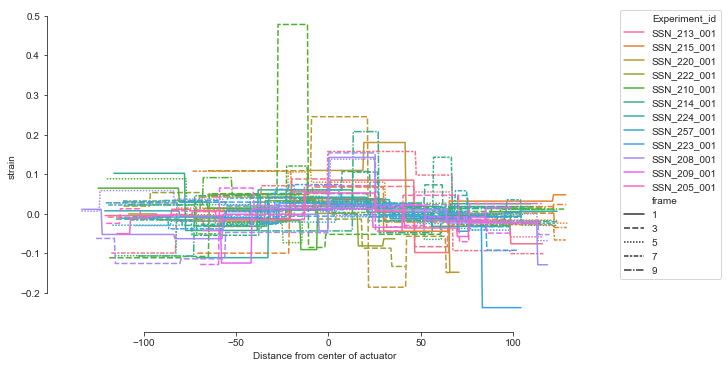

In [35]:
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
sns.lineplot(x='y', y='strain', ax=ax, hue='Experiment_id', style='frame', # ci=None, # style='',
             data=spatial_strain_df.loc[(spatial_strain_df['pressure'] == 300) &
                                        (spatial_strain_df['worm_strain'] == 'GN886')])
#                                         (spatial_strain_df['y_coord'] > -100) &
#                                         (spatial_strain_df['y_coord'] < 100)])

sns.despine(offset=10, trim=True)
ax.legend()
# h, labels = ax.get_legend_handles_labels()
# labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label]) + ' worms') if label in allele_dict else 'Allele' for label in labels]
# ax.legend(h, labels)# 
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax.set_xlabel('Distance from center of actuator');

### Max displacement vs. max strain

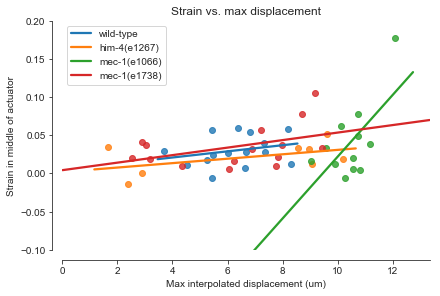

In [36]:
def get_strain_at_actuator(row):
    strain_val = spatial_strain_df.loc[
        (spatial_strain_df['Experiment_id'] == row['Experiment_id']) &
        (spatial_strain_df['pressure'] != 0) &
        (spatial_strain_df['y_coord'] == 0)]['strain'].mean()
    return strain_val    

fit_param_df['strain_at_actuator'] = fit_param_df.apply(get_strain_at_actuator, axis=1)


fig, ax = plt.subplots(constrained_layout=True)
for this_strain in worm_strains:
    sns.regplot(x='max_dist', y='strain_at_actuator', x_ci=None, ci=None, # hue='genotype',
                data=fit_param_df.loc[fit_param_df['worm_strain'] == this_strain])
sns.despine(offset=10)
ax.set_title('Strain vs. max displacement')
ax.set_ybound(-0.1, 0.2)
ax.set_xlabel('Max interpolated displacement (um)')
ax.set_ylabel('Strain in middle of actuator')
ax.legend(['wild-type', 'him-4(e1267)', 'mec-1(e1066)', 'mec-1(e1738)'])
fig.savefig(fig_save_dir + 'strain_vs_max_displacement')

## Plots for figure 1 of paper
This figure is intended to show how the method for measuring strain works. I've chosen a trial with the maximum number of actuation events so it can be averaged.

- A) Max projection of mitochondria in the TRN of a worm. 
- B) Motion of mitochondria induced by mechanical stimulus. 
- C) Mechanical strain in the TRN at the location of maximum actuation. 
- D) Distribution of touch-induced strain in the TRN

### Max projection of first two frames

In [37]:
example_trial = 'SSN_151_001'
timestamp = metadata_df.loc[metadata_df['Experiment_id'] == example_trial]['timestamp'].values[0]
exp_dir = ''.join(str(timestamp)[:10].split('-'))
filename = pathlib.Path(raw_data_dir, exp_dir, example_trial + '.nd2')
bf_filename = filename.parent.joinpath(filename.stem + '_bf.nd2')
warnings.filterwarnings("ignore", message="Reported average frame interval")

(-0.5, 1049.5, 599.5, -0.5)

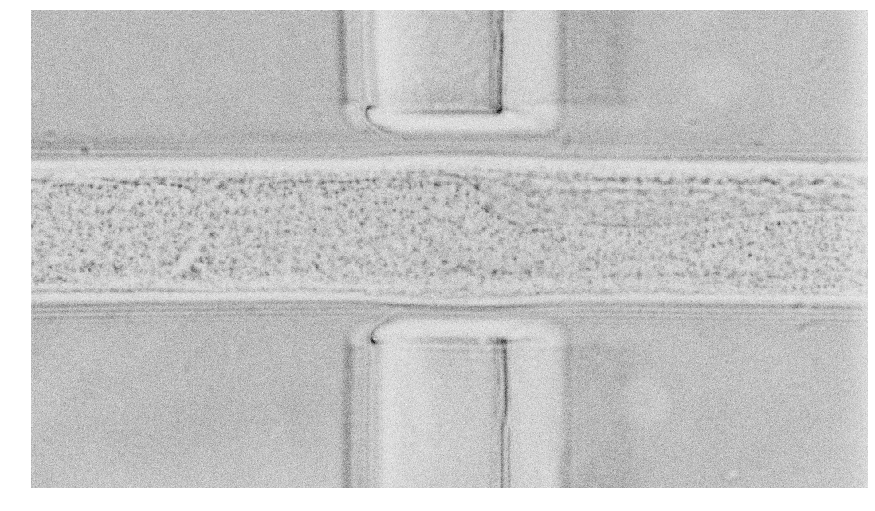

In [38]:
bf_image = pims.open(str(bf_filename))
bf_array = np.asarray(bf_image)
bf_array = bf_array.squeeze()
bf_array = np.rot90(bf_array,1,(0,1))
bf_array.shape

fig, ax = plt.subplots(figsize=(15,50))
ax.imshow(bf_array, cmap='binary')
plt.axis('off')

In [39]:
images = pims.open(str(filename))
images.bundle_axes = ['z', 'y', 'x']

imageArray = np.asarray(images)
imageArray = imageArray.squeeze()

maxProjection = np.amax(imageArray[0:2] ,1) # collapse z axis
maxProjection = maxProjection.squeeze()
maxProjection = np.asarray(maxProjection)
maxProjection = np.rot90(maxProjection,1,(1,2))


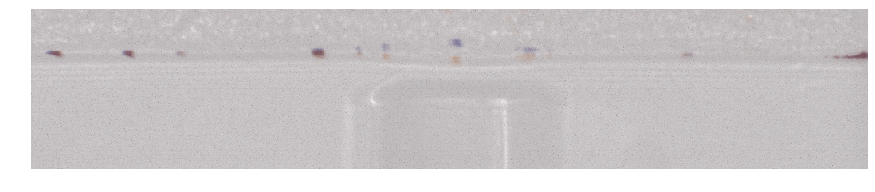

In [40]:
vmax = 150
vmin = maxProjection.min()
n_colors = vmax - vmin + 1
before_actuation_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_magenta', ['white', '#d95f02'], N=256)
after_actuation_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_green', ['white', '#7570b3'], N=256)
fig, ax = plt.subplots(figsize=(15,5))
ax.imshow(bf_array[300:500], cmap='gray')
ax.imshow(maxProjection[0, 300:500], cmap=before_actuation_cmap, alpha=0.5, vmax=vmax, vmin=vmin)
ax.imshow(maxProjection[1, 300:500], cmap=after_actuation_cmap, alpha=0.5, vmax=vmax, vmin=vmin)
plt.axis('off')
fig.savefig(fig_save_dir + 'DispOverlay')


In [41]:
# linked_mitos_df.loc[linked_mitos_df['genotype'] == 'wild-type'].groupby('Experiment_id', as_index=False).max()

## Sanity checks to make sure calculations didn't go horribly wrong
### Rest distances actually match previous particle locations

In [42]:
test_start = time.time()

stimulus_off_mitos = linked_mitos_df.loc[linked_mitos_df['pressure'] == 0]
pd.testing.assert_series_equal(stimulus_off_mitos['y'], stimulus_off_mitos['y_rest'], check_names=False)

for index, row in linked_mitos_df.iterrows():
    if row['pressure'] == 0:
        assert row['y_rest'] == row['y']
    else:
        current_y = row['y_rest']
        previous_y = linked_mitos_df.loc[
            (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
            (linked_mitos_df['frame'] == row['frame'] - 1) & 
            (linked_mitos_df['particle'] == row['particle'])]['y'].values[0]
        assert current_y == previous_y

### Displacements  and distances calculated correctly
For each dimension, check:
- Calculated displacements are the difference between the current position and the rest position
- Distances are the absolution value of displacements
- Some displacements are negative

In [43]:
for dim in ['x', 'y', 'z']:
    pd.testing.assert_series_equal(linked_mitos_df[dim + '_disp'],
                                   linked_mitos_df[dim] - linked_mitos_df[dim + '_rest'],
                                   check_names=False)
    pd.testing.assert_series_equal(linked_mitos_df[dim + '_dist'],
                                   linked_mitos_df[dim + '_disp'].abs(),
                                   check_names=False)
    try:
        pd.testing.assert_series_equal(linked_mitos_df[dim + '_disp'],
                                       linked_mitos_df[dim + '_disp'].abs(),
                                       check_names=False)
    except AssertionError:
        pass
    else:
        raise AssertionError('Some displacements should be negative')
    print('tested', dim, 'dimesion displacements.')


tested x dimesion displacements.
tested y dimesion displacements.
tested z dimesion displacements.


### Distances in multiple dimensions are vector sum of individual displacements

In [44]:
pd.testing.assert_series_equal(linked_mitos_df['xyz_dist'],
                              (linked_mitos_df[['x_dist', 'y_dist', 'z_dist']]**2).sum(axis=1)**0.5,
                              check_names=False)
pd.testing.assert_series_equal(linked_mitos_df['xz_dist'],
                              (linked_mitos_df[['x_dist', 'z_dist']]**2).sum(axis=1)**0.5,
                              check_names=False)

### Mitochondria pairs are correct


#### correct number of pairs for each trial

In [45]:
linked_mitos_grouped = linked_mitos_df.groupby(['Experiment_id', 'frame'])
paired_mitos_grouped = mito_pair_df.groupby(['Experiment_id', 'frame'])
pd.testing.assert_series_equal(linked_mitos_grouped['particle'].nunique() - 1,
                               paired_mitos_grouped['pair_id'].nunique(),
                               check_names=False)

- pair distance is correct using original particle locations
- pairs are in correct order
- distance calculation
- rest distances while we're at it
- stretch calculation
- strain calculation

In [46]:
for index, row in mito_pair_df.iterrows():
    p1_coords = linked_mitos_df.loc[
        (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
        (linked_mitos_df['frame'] == row['frame']) &
        (linked_mitos_df['particle'] == row['particle_1'])][['x','y','z']]
    p2_coords = linked_mitos_df.loc[
        (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
        (linked_mitos_df['frame'] == row['frame']) &
        (linked_mitos_df['particle'] == row['particle_2'])][['x','y','z']]
    this_dist = (p1_coords.subtract(p2_coords.values)**2).sum(axis=1)**0.5
    
    assert row['particle_1_yval'] == p1_coords['y'].values
    assert row['particle_2_yval'] == p2_coords['y'].values
    assert row['particle_1_yval'] < row['particle_2_yval']
    assert row['distance'] == this_dist.values
    
    # Rest distance
    if row['pressure'] == 0:
        assert row['rest_dist'] == row['distance']
    else:
        current_dist = row['rest_dist']
        previous_dist = mito_pair_df.loc[
            (mito_pair_df['Experiment_id'] == row['Experiment_id']) &
            (mito_pair_df['frame'] == row['frame'] - 1) & 
            (mito_pair_df['pair_id'] == row['pair_id'])]['distance'].values[0]
        assert current_dist == previous_dist
    
    assert row['stretch'] == row['distance'] - row['rest_dist']
    assert row['strain'] == row['stretch'] / row['rest_dist']

#### pressure values are maintained properly

In [47]:
pstart=time.time()
for index, row in linked_mitos_df.iterrows():
    assert row['pressure'] == metadata_df.loc[
        metadata_df['Experiment_id']==row['Experiment_id']][
        'pressure_kPa'].values[0][row['frame']]
for index, row in mito_pair_df.iterrows():
    assert row['pressure'] == metadata_df.loc[
        metadata_df['Experiment_id']==row['Experiment_id']][
        'pressure_kPa'].values[0][row['frame']]
# for index, row in spatial_strain_df.iterrows():
#     assert row['pressure'] == metadata_df.loc[
#         metadata_df['Experiment_id']==row['Experiment_id']][
#         'pressure_kPa'].values[0][row['frame']]
print(time.time()-pstart)

7.8620851039886475


### Coordinates for spatial average of strain are correct

In [48]:
print('Testing took', str(round(time.time()-test_start)), 'seconds.')
print('Notebook took', str(round((time.time()-start) / 60, 1)), 'minutes to run.')

Testing took 42 seconds.
Notebook took 5.2 minutes to run.
